In [16]:
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [2]:
with open('results/cloudlab_1800/latency_0_2024-05-08_17-13-26.json') as writer:
    data0 = json.load(writer)
with open('results/cloudlab_1800/latency_1_2024-05-08_17-13-26.json') as writer:
    data1 = json.load(writer)

In [3]:
data = {}
for key in data0:
    data[key] = sorted(data0[key] + data1[key])
data

{'order': [0.01926279067993164,
  0.019546031951904297,
  0.019957542419433594,
  0.020050525665283203,
  0.02008342742919922,
  0.02032756805419922,
  0.020355224609375,
  0.020485639572143555,
  0.020548343658447266,
  0.02059459686279297,
  0.02062845230102539,
  0.02082037925720215,
  0.02095198631286621,
  0.02133917808532715,
  0.021352767944335938,
  0.021586179733276367,
  0.02164173126220703,
  0.021644115447998047,
  0.02170395851135254,
  0.021717309951782227,
  0.021724700927734375,
  0.021755456924438477,
  0.021765947341918945,
  0.021837472915649414,
  0.021857738494873047,
  0.02198004722595215,
  0.02201533317565918,
  0.022034168243408203,
  0.022068500518798828,
  0.022153854370117188,
  0.022200584411621094,
  0.02226543426513672,
  0.02235698699951172,
  0.022581100463867188,
  0.022581815719604492,
  0.022803306579589844,
  0.022859573364257812,
  0.022939205169677734,
  0.022948026657104492,
  0.02300238609313965,
  0.023158788681030273,
  0.023197174072265625,
 

# Plots

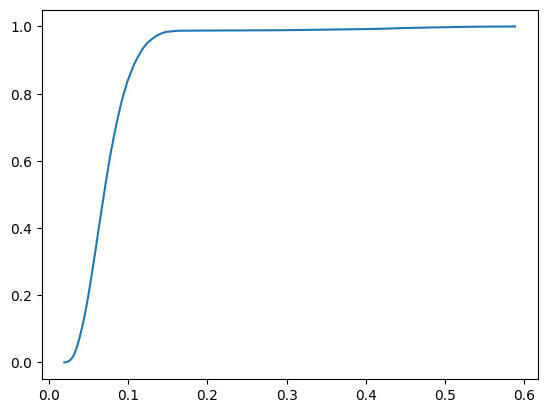

In [15]:
# Cumulative Distribution Function
cumsum = np.arange(1, len(data['order']) + 1) / len(data['order'])
plt.plot(data['order'], cumsum)
# plt.set_xlabel('Latency (ms)')
# ax.set_ylabel('Cumulative Probability')
# ax.set_title('Cumulative Distribution Function (CDF) of API Latencies')
plt.show()

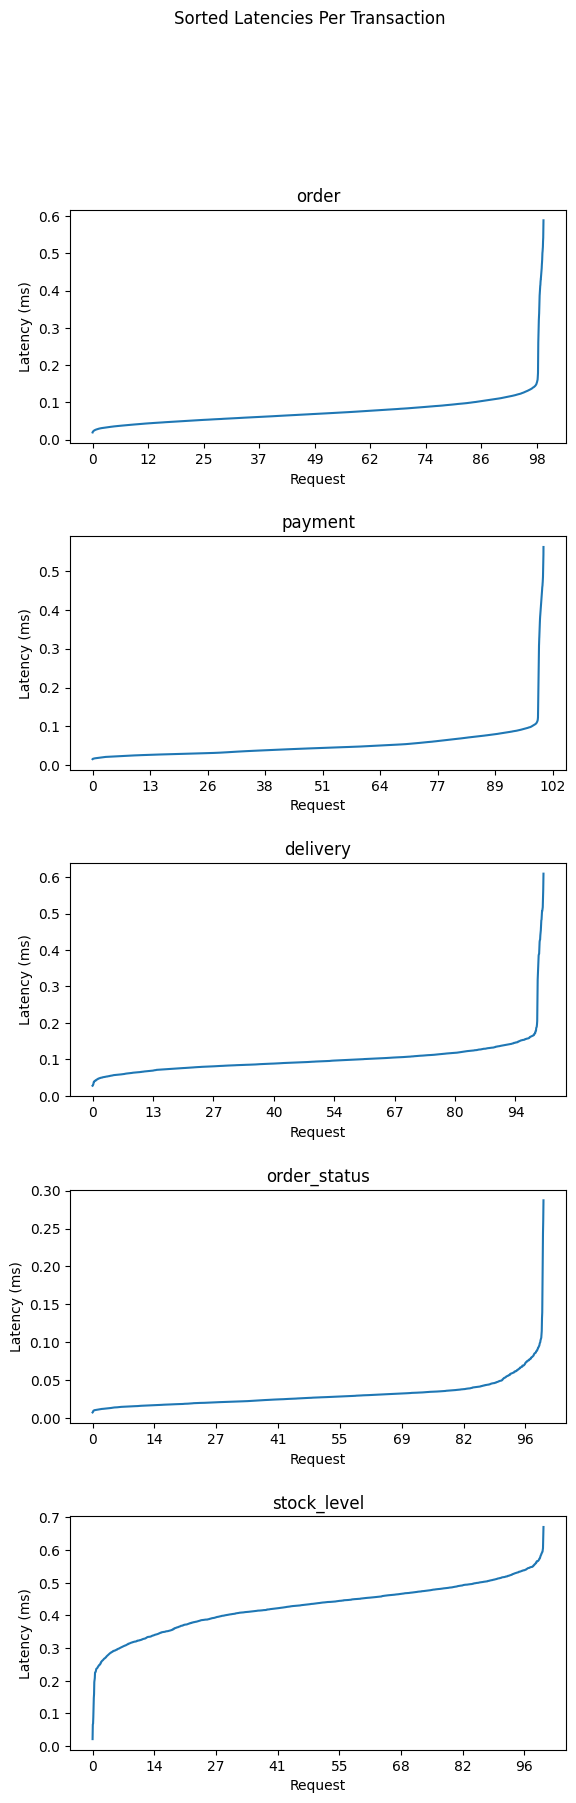

In [19]:
figure, axes = plt.subplots(nrows=5)
figure.set_figheight(20)
figure.subplots_adjust(hspace=0.4)
figure.suptitle('Sorted Latencies Per Transaction')
for i, key in enumerate(data):
    axes[i].plot(data[key])
    axes[i].set_title(key)
    axes[i].set_xlabel('Request')
    axes[i].set_ylabel('Latency (ms)')
    axes[i].xaxis.set_major_formatter(mtick.PercentFormatter(len(data[key]), symbol=''))
figure.savefig('results/cloudlab_1800/sorted_latency.png')

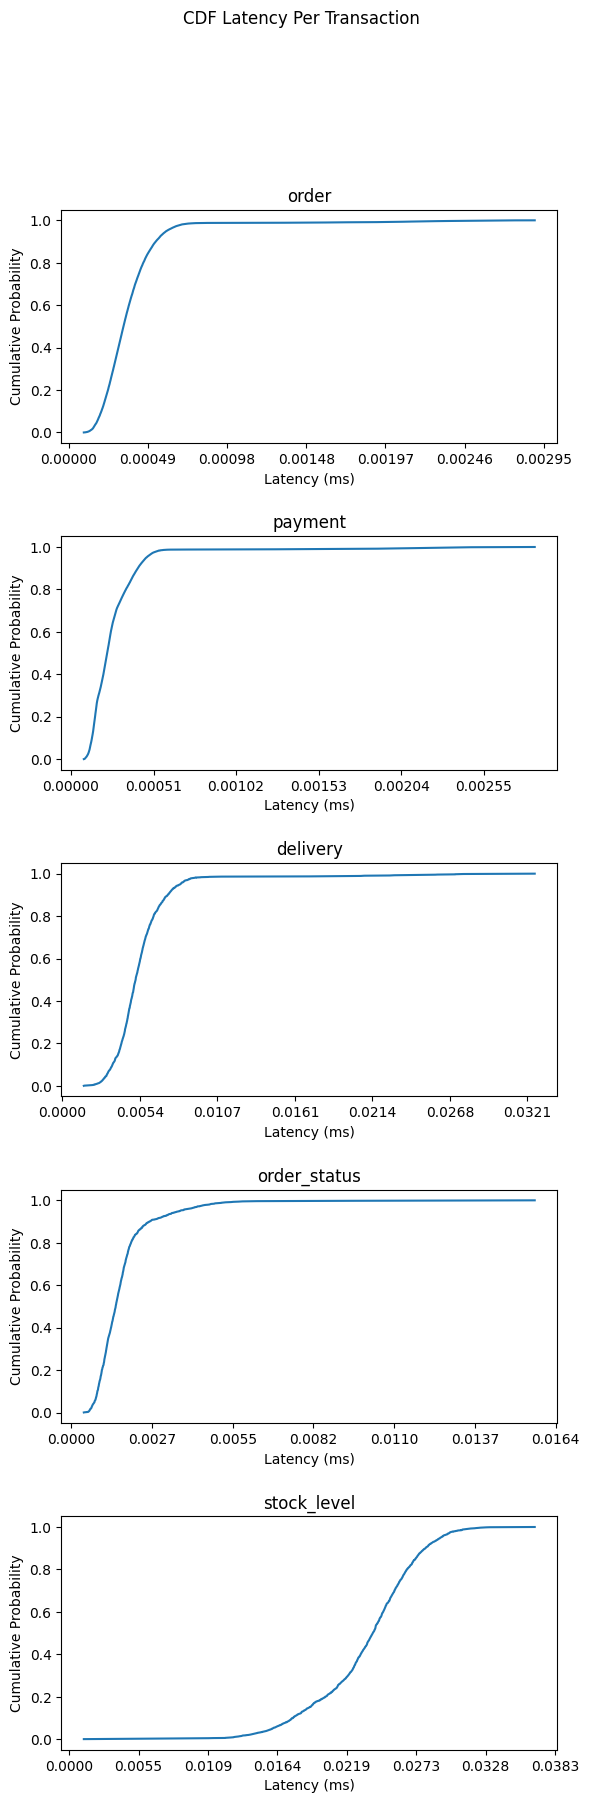

In [18]:
# Cumulative Distribution Function
figure, axes = plt.subplots(nrows=5)
figure.set_figheight(20)
figure.subplots_adjust(hspace=0.4)
figure.suptitle('CDF Latency Per Transaction')
for i, key in enumerate(data):
    cumsum = np.arange(1, len(data[key]) + 1) / len(data[key])
    axes[i].plot(data[key], cumsum)
    axes[i].set_title(key)
    axes[i].set_xlabel('Latency (ms)')
    axes[i].set_ylabel('Cumulative Probability')
    axes[i].xaxis.set_major_formatter(mtick.PercentFormatter(len(data[key]), symbol=''))
figure.savefig('results/cloudlab_1800/cdf_latency.png')

# Metrics

In [6]:
import pandas as pd

In [7]:
latency_series = {key: pd.Series(data[key]) for key in data}
latency_series

{'order': 0        0.019263
 1        0.019546
 2        0.019958
 3        0.020051
 4        0.020083
            ...   
 20301    0.557218
 20302    0.563715
 20303    0.567555
 20304    0.567971
 20305    0.588372
 Length: 20306, dtype: float64,
 'payment': 0        0.015562
 1        0.015827
 2        0.015837
 3        0.015839
 4        0.015981
            ...   
 19591    0.535012
 19592    0.538837
 19593    0.542601
 19594    0.559863
 19595    0.561961
 Length: 19596, dtype: float64,
 'delivery': 0       0.027688
 1       0.027972
 2       0.030490
 3       0.031544
 4       0.035726
           ...   
 1862    0.511355
 1863    0.517596
 1864    0.542033
 1865    0.566937
 1866    0.609456
 Length: 1867, dtype: float64,
 'order_status': 0       0.007761
 1       0.008052
 2       0.008963
 3       0.009731
 4       0.010181
           ...   
 1819    0.175244
 1820    0.204110
 1821    0.243958
 1822    0.260712
 1823    0.287106
 Length: 1824, dtype: float64,
 'stock_leve

In [8]:
latency_quantiles = [[key,
                      round(latency_series[key].quantile(q=0.5), 4),
                      round(latency_series[key].quantile(q=0.9), 4),
                      round(latency_series[key].quantile(q=0.95), 4),
                      round(latency_series[key].quantile(q=0.99), 4)]
                     for key in latency_series]
df = pd.DataFrame(latency_quantiles, columns=['Transaction', 'P50', 'P90', 'P95', 'P99'])
df.to_csv('results/cloudlab_1800/latency_quantiles.csv', index=False)
df

,Transaction,P50,P90,P95,P99
0,order,0.0693,0.1102,0.1236,0.3309
1,payment,0.0440,0.0810,0.0912,0.3046
2,delivery,0.0945,0.1360,0.1520,0.3888
3,order_status,0.0275,0.0485,0.0672,0.0951
4,stock_level,0.4376,0.5132,0.5352,0.5705
